### BaseLine Module

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch import optim
from torchvision.transforms.transforms import Resize
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import time 
import sys
from sklearn import metrics
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

import copy
import logging

In [ ]:
# gaussian error linear unit as Af
def gelu(x):
    return torch.sigmoid(1.702 * x) * x


class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1,10,kernel_size=5)
    self.conv2 = nn.Conv2d(10 ,20 ,kernel_size=5)
    self.dropout = nn.Dropout()
    self.fc1 = nn.Linear(320,50)
    self.fc2 = nn.Linear(50 ,10)
  
  def forward(self,x):
    x = gelu(F.max_pool2d(self.conv1(x),2))
    x = self.conv2(x)
    x = self.dropout(x)
    x = F.max_pool2d(x,2)
    x = gelu(x)
    x = x.view(-1 ,320)
    x = self.fc1(x)
    x = gelu(x)
    x = self.fc2(x)
    return x 



### **Data & Preprocessing**

In [ ]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

PATH = './MNIST_OSR.pth'
# Torch/PIL transformations which are applied to each image in the dataset
transform = transforms.Compose([
                    transforms.Resize((28,28)),
                    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,)),
                    ])

# no need for augmentations for our evaluation
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

ood_transform = transforms.Compose([
                    transforms.Resize((28,28)),
                    transforms.Grayscale(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,)),
                    ])
batch_size = 128
torch.manual_seed(0)
np.random.seed(0)

oodset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=ood_transform)
oodset,_ = torch.utils.data.random_split(oodset,[300,len(oodset)-300])

oodloader = torch.utils.data.DataLoader(oodset,batch_size=batch_size,shuffle=False,num_workers=4)


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=test_transform)

val_size = int(0.2 * len(trainset))
trainset ,validationset = torch.utils.data.random_split(trainset,[(len(trainset)-val_size),val_size])

#####################################################

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True,
                                           num_workers=4)

valoader = torch.utils.data.DataLoader(validationset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

dataloader = {'train':trainloader , 'validation':valoader}
dataset_sizes = {"train": len(trainset),'validation':len(validationset)}

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   

if torch.cuda.is_available():
  print('GPU NAME:', torch.cuda.get_device_name(0)) 

model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
scheduler= optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5, eta_min=0, last_epoch=-1)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

GPU NAME: Tesla T4


### **Training**

In [ ]:
def train_model(model,dataloader,dataset_sizes,criterion,optimizer,scheduler,epochs=30):
    # Define Forward Procedure
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                    
                if phase == 'train':
                    scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            logger.info('{} Loss: {:.4f}; {} Acc: {:.4f};'.format(
                phase, epoch_loss, phase, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        logger.info('epoch: {}; lr: {};'.format(epoch+1, scheduler.get_last_lr()[0]))       
        print()                        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best validation Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # save the model
    torch.save(model.state_dict(), PATH)
    print()
    
    # Evaluate best model weights
    print('Evaluating best weights:')
    print('-' * 20)
    
    model = model.to(device)
    
    model.eval()
    
    for phase in dataloader:

        running_loss = 0.0
        running_corrects = 0
        
        # Store results in nested dicts per dataset being used for inference
        results = {'y_true': [], 'y_pred': []}

        # Iterate over data.
        for inputs, labels in dataloader[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            labels_arr = np.array(labels.data.cpu())
            preds_arr = np.array(preds.cpu())

            results['y_true'].append(labels.data.cpu())
            results['y_pred'].append(preds.cpu())

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        results['y_true'] = np.array(torch.cat(results['y_true']))
        results['y_pred'] = np.array(torch.cat(results['y_pred']))

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
        
        # Compute average F1 score (class f1 scores are weighted according to relative class frequency)
        f1_scores = metrics.f1_score(results['y_true'], 
                                 results['y_pred'],
                                 average='weighted')

        avg_f1 = np.mean(f1_scores)

        logger.info('{} Avg. F1 Score: {:.3f};'.format(phase, avg_f1))

        print()


In [ ]:
def test(model,testloader):
    model.eval()
    loss_avg = 0.0
    correct = 0
    labels = list(range(10))
    results = {'y_true': [], 'y_pred': []}
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)

            # forward
            output = model(data)
            loss = F.cross_entropy(output, target)

            # accuracy
            pred = output.data.max(1)[1]
            results['y_true'].append(target.data.cpu())
            results['y_pred'].append(pred.cpu())
            correct += pred.eq(target.data).sum().item()
            # test loss average
            loss_avg += float(loss.data)
    results['y_true'] = np.array(torch.cat(results['y_true']))
    results['y_pred'] = np.array(torch.cat(results['y_pred']))
    # print(results['y_pred'])
    # print(results['y_true'])
    mat = confusion_matrix(results['y_true'],results['y_pred'])
    disp = ConfusionMatrixDisplay(mat,display_labels=labels)
    disp.plot()
    print("test accuracy : ",correct / len(testloader.dataset))
    plt.show()

train and Save the model

Epoch 1/30
----------
train Loss: 1.9336; train Acc: 0.3152;


INFO:__main__:train Loss: 1.9336; train Acc: 0.3152;


validation Loss: 1.3013; validation Acc: 0.6499;


INFO:__main__:validation Loss: 1.3013; validation Acc: 0.6499;


epoch: 1; lr: 0.003;


INFO:__main__:epoch: 1; lr: 0.003;



Epoch 2/30
----------
train Loss: 0.7888; train Acc: 0.7473;


INFO:__main__:train Loss: 0.7888; train Acc: 0.7473;


validation Loss: 0.6431; validation Acc: 0.8434;


INFO:__main__:validation Loss: 0.6431; validation Acc: 0.8434;


epoch: 2; lr: 0.003;


INFO:__main__:epoch: 2; lr: 0.003;



Epoch 3/30
----------
train Loss: 0.4732; train Acc: 0.8521;


INFO:__main__:train Loss: 0.4732; train Acc: 0.8521;


validation Loss: 0.4506; validation Acc: 0.8960;


INFO:__main__:validation Loss: 0.4506; validation Acc: 0.8960;


epoch: 3; lr: 0.003;


INFO:__main__:epoch: 3; lr: 0.003;



Epoch 4/30
----------
train Loss: 0.3648; train Acc: 0.8855;


INFO:__main__:train Loss: 0.3648; train Acc: 0.8855;


validation Loss: 0.3526; validation Acc: 0.9201;


INFO:__main__:validation Loss: 0.3526; validation Acc: 0.9201;


epoch: 4; lr: 0.003;


INFO:__main__:epoch: 4; lr: 0.003;



Epoch 5/30
----------
train Loss: 0.3068; train Acc: 0.9056;


INFO:__main__:train Loss: 0.3068; train Acc: 0.9056;


validation Loss: 0.2978; validation Acc: 0.9327;


INFO:__main__:validation Loss: 0.2978; validation Acc: 0.9327;


epoch: 5; lr: 0.003;


INFO:__main__:epoch: 5; lr: 0.003;



Epoch 6/30
----------
train Loss: 0.2665; train Acc: 0.9201;


INFO:__main__:train Loss: 0.2665; train Acc: 0.9201;


validation Loss: 0.2732; validation Acc: 0.9372;


INFO:__main__:validation Loss: 0.2732; validation Acc: 0.9372;


epoch: 6; lr: 0.003;


INFO:__main__:epoch: 6; lr: 0.003;



Epoch 7/30
----------
train Loss: 0.2442; train Acc: 0.9242;


INFO:__main__:train Loss: 0.2442; train Acc: 0.9242;


validation Loss: 0.2445; validation Acc: 0.9440;


INFO:__main__:validation Loss: 0.2445; validation Acc: 0.9440;


epoch: 7; lr: 0.003;


INFO:__main__:epoch: 7; lr: 0.003;



Epoch 8/30
----------
train Loss: 0.2246; train Acc: 0.9317;


INFO:__main__:train Loss: 0.2246; train Acc: 0.9317;


validation Loss: 0.2274; validation Acc: 0.9485;


INFO:__main__:validation Loss: 0.2274; validation Acc: 0.9485;


epoch: 8; lr: 0.003;


INFO:__main__:epoch: 8; lr: 0.003;



Epoch 9/30
----------
train Loss: 0.2065; train Acc: 0.9374;


INFO:__main__:train Loss: 0.2065; train Acc: 0.9374;


validation Loss: 0.2165; validation Acc: 0.9499;


INFO:__main__:validation Loss: 0.2165; validation Acc: 0.9499;


epoch: 9; lr: 0.003;


INFO:__main__:epoch: 9; lr: 0.003;



Epoch 10/30
----------
train Loss: 0.1966; train Acc: 0.9402;


INFO:__main__:train Loss: 0.1966; train Acc: 0.9402;


validation Loss: 0.1956; validation Acc: 0.9532;


INFO:__main__:validation Loss: 0.1956; validation Acc: 0.9532;


epoch: 10; lr: 0.003;


INFO:__main__:epoch: 10; lr: 0.003;



Epoch 11/30
----------
train Loss: 0.1854; train Acc: 0.9430;


INFO:__main__:train Loss: 0.1854; train Acc: 0.9430;


validation Loss: 0.1804; validation Acc: 0.9572;


INFO:__main__:validation Loss: 0.1804; validation Acc: 0.9572;


epoch: 11; lr: 0.003;


INFO:__main__:epoch: 11; lr: 0.003;



Epoch 12/30
----------
train Loss: 0.1722; train Acc: 0.9472;


INFO:__main__:train Loss: 0.1722; train Acc: 0.9472;


validation Loss: 0.1743; validation Acc: 0.9607;


INFO:__main__:validation Loss: 0.1743; validation Acc: 0.9607;


epoch: 12; lr: 0.003;


INFO:__main__:epoch: 12; lr: 0.003;



Epoch 13/30
----------
train Loss: 0.1664; train Acc: 0.9486;


INFO:__main__:train Loss: 0.1664; train Acc: 0.9486;


validation Loss: 0.1636; validation Acc: 0.9616;


INFO:__main__:validation Loss: 0.1636; validation Acc: 0.9616;


epoch: 13; lr: 0.003;


INFO:__main__:epoch: 13; lr: 0.003;



Epoch 14/30
----------
train Loss: 0.1594; train Acc: 0.9506;


INFO:__main__:train Loss: 0.1594; train Acc: 0.9506;


validation Loss: 0.1549; validation Acc: 0.9657;


INFO:__main__:validation Loss: 0.1549; validation Acc: 0.9657;


epoch: 14; lr: 0.003;


INFO:__main__:epoch: 14; lr: 0.003;



Epoch 15/30
----------
train Loss: 0.1500; train Acc: 0.9544;


INFO:__main__:train Loss: 0.1500; train Acc: 0.9544;


validation Loss: 0.1574; validation Acc: 0.9637;


INFO:__main__:validation Loss: 0.1574; validation Acc: 0.9637;


epoch: 15; lr: 0.003;


INFO:__main__:epoch: 15; lr: 0.003;



Epoch 16/30
----------
train Loss: 0.1470; train Acc: 0.9556;


INFO:__main__:train Loss: 0.1470; train Acc: 0.9556;


validation Loss: 0.1484; validation Acc: 0.9667;


INFO:__main__:validation Loss: 0.1484; validation Acc: 0.9667;


epoch: 16; lr: 0.003;


INFO:__main__:epoch: 16; lr: 0.003;



Epoch 17/30
----------
train Loss: 0.1415; train Acc: 0.9561;


INFO:__main__:train Loss: 0.1415; train Acc: 0.9561;


validation Loss: 0.1564; validation Acc: 0.9623;


INFO:__main__:validation Loss: 0.1564; validation Acc: 0.9623;


epoch: 17; lr: 0.003;


INFO:__main__:epoch: 17; lr: 0.003;



Epoch 18/30
----------
train Loss: 0.1367; train Acc: 0.9579;


INFO:__main__:train Loss: 0.1367; train Acc: 0.9579;


validation Loss: 0.1379; validation Acc: 0.9681;


INFO:__main__:validation Loss: 0.1379; validation Acc: 0.9681;


epoch: 18; lr: 0.003;


INFO:__main__:epoch: 18; lr: 0.003;



Epoch 19/30
----------
train Loss: 0.1334; train Acc: 0.9592;


INFO:__main__:train Loss: 0.1334; train Acc: 0.9592;


validation Loss: 0.1284; validation Acc: 0.9714;


INFO:__main__:validation Loss: 0.1284; validation Acc: 0.9714;


epoch: 19; lr: 0.003;


INFO:__main__:epoch: 19; lr: 0.003;



Epoch 20/30
----------
train Loss: 0.1328; train Acc: 0.9591;


INFO:__main__:train Loss: 0.1328; train Acc: 0.9591;


validation Loss: 0.1223; validation Acc: 0.9709;


INFO:__main__:validation Loss: 0.1223; validation Acc: 0.9709;


epoch: 20; lr: 0.003;


INFO:__main__:epoch: 20; lr: 0.003;



Epoch 21/30
----------
train Loss: 0.1271; train Acc: 0.9610;


INFO:__main__:train Loss: 0.1271; train Acc: 0.9610;


validation Loss: 0.1192; validation Acc: 0.9722;


INFO:__main__:validation Loss: 0.1192; validation Acc: 0.9722;


epoch: 21; lr: 0.003;


INFO:__main__:epoch: 21; lr: 0.003;



Epoch 22/30
----------
train Loss: 0.1235; train Acc: 0.9617;


INFO:__main__:train Loss: 0.1235; train Acc: 0.9617;


validation Loss: 0.1236; validation Acc: 0.9723;


INFO:__main__:validation Loss: 0.1236; validation Acc: 0.9723;


epoch: 22; lr: 0.003;


INFO:__main__:epoch: 22; lr: 0.003;



Epoch 23/30
----------
train Loss: 0.1209; train Acc: 0.9627;


INFO:__main__:train Loss: 0.1209; train Acc: 0.9627;


validation Loss: 0.1203; validation Acc: 0.9716;


INFO:__main__:validation Loss: 0.1203; validation Acc: 0.9716;


epoch: 23; lr: 0.003;


INFO:__main__:epoch: 23; lr: 0.003;



Epoch 24/30
----------
train Loss: 0.1155; train Acc: 0.9636;


INFO:__main__:train Loss: 0.1155; train Acc: 0.9636;


validation Loss: 0.1178; validation Acc: 0.9697;


INFO:__main__:validation Loss: 0.1178; validation Acc: 0.9697;


epoch: 24; lr: 0.003;


INFO:__main__:epoch: 24; lr: 0.003;



Epoch 25/30
----------
train Loss: 0.1160; train Acc: 0.9643;


INFO:__main__:train Loss: 0.1160; train Acc: 0.9643;


validation Loss: 0.1147; validation Acc: 0.9735;


INFO:__main__:validation Loss: 0.1147; validation Acc: 0.9735;


epoch: 25; lr: 0.003;


INFO:__main__:epoch: 25; lr: 0.003;



Epoch 26/30
----------
train Loss: 0.1139; train Acc: 0.9660;


INFO:__main__:train Loss: 0.1139; train Acc: 0.9660;


validation Loss: 0.1153; validation Acc: 0.9734;


INFO:__main__:validation Loss: 0.1153; validation Acc: 0.9734;


epoch: 26; lr: 0.003;


INFO:__main__:epoch: 26; lr: 0.003;



Epoch 27/30
----------
train Loss: 0.1099; train Acc: 0.9656;


INFO:__main__:train Loss: 0.1099; train Acc: 0.9656;


validation Loss: 0.1072; validation Acc: 0.9758;


INFO:__main__:validation Loss: 0.1072; validation Acc: 0.9758;


epoch: 27; lr: 0.003;


INFO:__main__:epoch: 27; lr: 0.003;



Epoch 28/30
----------
train Loss: 0.1082; train Acc: 0.9660;


INFO:__main__:train Loss: 0.1082; train Acc: 0.9660;


validation Loss: 0.1114; validation Acc: 0.9752;


INFO:__main__:validation Loss: 0.1114; validation Acc: 0.9752;


epoch: 28; lr: 0.003;


INFO:__main__:epoch: 28; lr: 0.003;



Epoch 29/30
----------
train Loss: 0.1091; train Acc: 0.9653;


INFO:__main__:train Loss: 0.1091; train Acc: 0.9653;


validation Loss: 0.1059; validation Acc: 0.9757;


INFO:__main__:validation Loss: 0.1059; validation Acc: 0.9757;


epoch: 29; lr: 0.003;


INFO:__main__:epoch: 29; lr: 0.003;



Epoch 30/30
----------
train Loss: 0.1028; train Acc: 0.9684;


INFO:__main__:train Loss: 0.1028; train Acc: 0.9684;


validation Loss: 0.1022; validation Acc: 0.9770;


INFO:__main__:validation Loss: 0.1022; validation Acc: 0.9770;


epoch: 30; lr: 0.003;


INFO:__main__:epoch: 30; lr: 0.003;



Training complete in 16m 7s
Best validation Acc: 0.977000

Evaluating best weights:
--------------------
train Loss: 0.0987 Acc: 0.9764
train Avg. F1 Score: 0.976;


INFO:__main__:train Avg. F1 Score: 0.976;


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


validation Loss: 0.0990 Acc: 0.9769
validation Avg. F1 Score: 0.977;


INFO:__main__:validation Avg. F1 Score: 0.977;


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


test accuracy :  0.9892


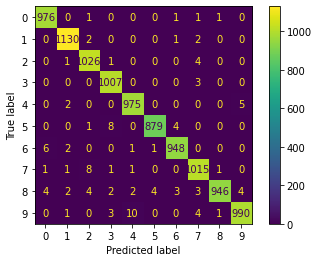

In [ ]:
train_model(model,dataloader,dataset_sizes,criterion,optimizer,scheduler)
test(model,testloader)

load a trained model

In [ ]:
# model = ConvNet()
# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['net'])

### Open Set Recognition (OpenMax) 
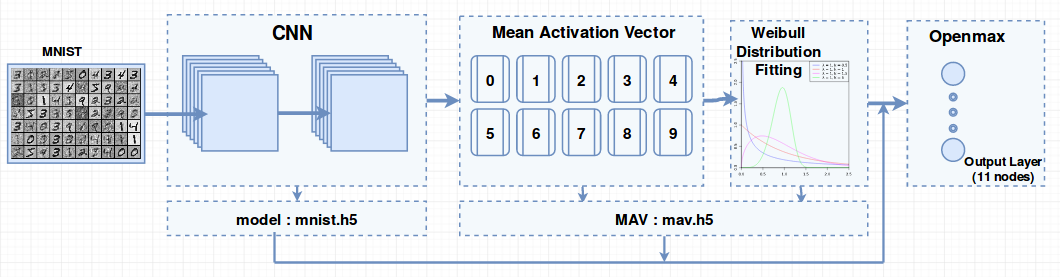

*this code is based on this paper(Towards Open Set Deep Networks
):*
https://arxiv.org/abs/1511.06233 \\
I use libMR library which provides core MetaRecognition and Weibull fitting functionality. It is used to calculate w-scores used for multi-modal fusion, renormalize SVM data and in general support open-set algorithms with outlier detection



In [ ]:
import numpy as np
import scipy.spatial.distance as spd
import torch

import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
install("libmr")
import libmr

In [ ]:
def calc_distance(query_score, mcv, eu_weight, distance_type='eucos'):
    if distance_type == 'eucos':
        query_distance = spd.euclidean(mcv, query_score) * eu_weight + \
            spd.cosine(mcv, query_score)
    elif distance_type == 'euclidean':
        query_distance = spd.euclidean(mcv, query_score)
    elif distance_type == 'cosine':
        query_distance = spd.cosine(mcv, query_score)
    else:
        print("distance type not known: enter either of eucos, euclidean or cosine")
    return query_distance


def fit_weibull(means, dists, categories, tailsize=10, distance_type='eucos'):
    """
    Input:
        means (C, channel, C)
        dists (N_c, channel, C) * C
    Output:
        weibull_model : Perform EVT based analysis using tails of distances and save
                        weibull model parameters for re-adjusting softmax scores
    """
    weibull_model = {}
    for mean, dist, category_name in zip(means, dists, categories):
        weibull_model[category_name] = {}
        weibull_model[category_name]['distances_{}'.format(distance_type)] = dist[distance_type]
        weibull_model[category_name]['mean_vec'] = mean
        weibull_model[category_name]['weibull_model'] = []
        for channel in range(mean.shape[0]):
            mr = libmr.MR()
            tailtofit = np.sort(dist[distance_type][channel, :])[-tailsize:]
            mr.fit_high(tailtofit, len(tailtofit))
            weibull_model[category_name]['weibull_model'].append(mr)

    return weibull_model


def query_weibull(category_name, weibull_model, distance_type='eucos'):
    return [weibull_model[category_name]['mean_vec'],
            weibull_model[category_name]['distances_{}'.format(distance_type)],
            weibull_model[category_name]['weibull_model']]


def compute_openmax_prob(scores, scores_u):
    prob_scores, prob_unknowns = [], []
    for s, su in zip(scores, scores_u):
        channel_scores = np.exp(s)
        channel_unknown = np.exp(np.sum(su))

        total_denom = np.sum(channel_scores) + channel_unknown
        prob_scores.append(channel_scores / total_denom)
        prob_unknowns.append(channel_unknown / total_denom)

    # Take channel mean
    scores = np.mean(prob_scores, axis=0)
    unknowns = np.mean(prob_unknowns, axis=0)
    modified_scores = scores.tolist() + [unknowns]
    return modified_scores




def openmax(weibull_model, categories, input_score, eu_weight, alpha=6, distance_type='eucos'):
    """Re-calibrate scores via OpenMax layer
    Output:
        openmax probability
    """
    nb_classes = len(categories)

    ranked_list = input_score.argsort().ravel()[::-1][:alpha]
    alpha_weights = [((alpha + 1) - i) / float(alpha) for i in range(1, alpha + 1)]
    omega = np.zeros(nb_classes)
    omega[ranked_list] = alpha_weights

    scores, scores_u = [], []
    for channel, input_score_channel in enumerate(input_score):
        score_channel, score_channel_u = [], []
        for c, category_name in enumerate(categories):
            mav, dist, model = query_weibull(category_name, weibull_model, distance_type)
            channel_dist = calc_distance(input_score_channel, mav[channel], eu_weight, distance_type)
            wscore = model[channel].w_score(channel_dist)
            modified_score = input_score_channel[c] * (1 - wscore * omega[c])
            score_channel.append(modified_score)
            score_channel_u.append(input_score_channel[c] - modified_score)

        scores.append(score_channel)
        scores_u.append(score_channel_u)

    scores = np.asarray(scores)
    scores_u = np.asarray(scores_u)

    openmax_prob = np.array(compute_openmax_prob(scores, scores_u))
    return openmax_prob


def compute_channel_distances(mavs, features, eu_weight=0.5):
    """
    Input:
        mavs (channel, C)
        features: (N, channel, C)
    Output:
        channel_distances: dict of distance distribution from MAV for each channel.
    """
    eucos_dists, eu_dists, cos_dists = [], [], []
    for channel, mcv in enumerate(mavs):  # Compute channel specific distances
        eu_dists.append([spd.euclidean(mcv, feat[channel]) for feat in features])
        cos_dists.append([spd.cosine(mcv, feat[channel]) for feat in features])
        eucos_dists.append([spd.euclidean(mcv, feat[channel]) * eu_weight +
                            spd.cosine(mcv, feat[channel]) for feat in features])

    return {'eucos': np.array(eucos_dists), 'cosine': np.array(cos_dists), 'euclidean': np.array(eu_dists)}


def compute_train_score_and_mavs_and_dists(train_class_num,trainloader,device,net):
    scores = [[] for _ in range(train_class_num)]
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            # this must cause error for cifar
            outputs = net(inputs)
            for score, t in zip(outputs, targets):
                if torch.argmax(score) == t:
                    scores[t].append(score.unsqueeze(dim=0).unsqueeze(dim=0))
    scores = [torch.cat(x).cpu().numpy() for x in scores]  # (N_c, 1, C) * C
    mavs = np.array([np.mean(x, axis=0) for x in scores])  # (C, 1, C)
    dists = [compute_channel_distances(mcv, score) for mcv, score in zip(mavs, scores)]
    return scores, mavs, dists

In [ ]:
def OOD_test(net,trainloader, oodtest,criterion):
    net.eval()

    test_loss = 0
    correct = 0
    total = 0

    scores, labels = [], []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(oodtest):
            inputs = inputs.to(device)
            outputs = net(inputs)
            targets = [10] * len(targets)
            targets = torch.tensor(targets)
            scores.append(outputs)
            labels.append(targets)

    # Get the prdict results.
    scores = torch.cat(scores,dim=0).cpu().numpy()
    labels = torch.cat(labels,dim=0).cpu().numpy()
    scores = np.array(scores)[:, np.newaxis, :]
    labels = np.array(labels)

    # Fit the weibull distribution from training data.
    print("Fittting Weibull distribution...")
    _, mavs, dists = compute_train_score_and_mavs_and_dists(10, trainloader, device, net)
    categories = list(range(0, 10))
    weibull_model = fit_weibull(mavs, dists, categories,tailsize=10)

    pred_openmax = []
    score_openmax = []
    sum = 0
    predlist = []
    for score in scores:
        so = openmax(weibull_model, categories, score,
                         0.9, 6)  # openmax_prob, softmax_prob
        # print(np.argmax(so))
        predicted = np.argmax(so)
        predlist.append(predicted)
        if predicted == 10 :
          sum+=1

    print("openmax accuracy is  :" , (sum)*100/len(scores))  
    return labels,predlist

############################

def in_dist_test(net,trainloader, oodtest,criterion):
    net.eval()

    test_loss = 0
    correct = 0
    total = 0

    scores, labels = [], []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(oodtest):
            inputs = inputs.to(device)
            outputs = net(inputs)
            scores.append(outputs)
            labels.append(targets)

    # Get the prdict results.
    scores = torch.cat(scores,dim=0).cpu().numpy()
    labels = torch.cat(labels,dim=0).cpu().numpy()
    scores = np.array(scores)[:, np.newaxis, :]
    labels = np.array(labels)

    # Fit the weibull distribution from training data.
    print("Fittting Weibull distribution...")
    _, mavs, dists = compute_train_score_and_mavs_and_dists(10, trainloader, device, net)
    categories = list(range(0, 10))
    weibull_model = fit_weibull(mavs, dists, categories,tailsize=10)

    pred_openmax = []
    score_openmax = []
    sum = 0
    predlist = []
    for score in scores:
        so = openmax(weibull_model, categories, score,
                         0.9, 6)  # openmax_prob, softmax_prob
        # print(np.argmax(so))
        predicted = np.argmax(so)
        predlist.append(predicted)

    return labels,predlist


In [ ]:
ood_labels,ood_preds = OOD_test(model,dataloader['train'],oodloader,criterion)

in_dist_labels , in_dist_preds = in_dist_test(model , dataloader['train'] , testloader,criterion)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Fittting Weibull distribution...
openmax accuracy is  : 56.333333333333336
Fittting Weibull distribution...


The total accuracy is : 74.77669902912622


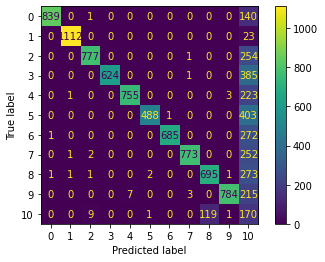

In [ ]:
true_labels =np.concatenate((ood_labels ,in_dist_labels))
preds =np.concatenate((ood_preds ,in_dist_preds)) 
# compute the total accuracy
acc = 0
for x,y in zip(true_labels , preds):
  if x == y :
    acc+=1

acc = acc/len(true_labels)
print("The total accuracy is :" ,acc*100 )
mat = confusion_matrix(true_labels,preds)
disp = ConfusionMatrixDisplay(mat ,display_labels=list(range(11)))
disp.plot()
plt.show()


## discuss
the openMax model will performe diffrently on other odd and that because each data need to fit it with the right (optim) parameters, for example in my case I try diffrent wights & alpha's and at the end I take what the paper suggest.